# Starwarps Example

In [1]:
# Note: this is an example sequence of commands to run in ipython that generates a movie
# from a single night of observation. 
#
# Contact Katie Bouman (klbouman@mit.edu) for any questions 
#
# The methods/techniques used in this, referred to as StarWars, are described in 
# "Reconstructing Video from Interferometric Measurements of Time-Varying Sources" 
# by Katherine L. Bouman, Michael D. Johnson, Adrian V. Dalca, 
# Andrew Chael, Freek Roelofs, Sheperd S. Doeleman, and William T. Freeman

# Note: must import ehtim outside the ehtim directory
# either in parent eht-imaging directory or after installing with setuptools
from __future__ import division
from __future__ import print_function

import numpy as np
import ehtim as eh
from   ehtim.calibrating import self_cal as sc
from ehtim.imaging import patch_prior as pp
import ehtim.image as image

# from ehtim.imaging import starwarps as sw
import starwarps_mod as sw

import matplotlib.pyplot as plt
import sys, os, copy
import scipy
import scipy.optimize as opt
import os
import ehtim.imaging.dynamical_imaging as di


Welcome to eht-imaging! v 1.2.2 



## Set parameters

In [2]:
# #path to uvfits -- here we have focused on region 3 which has best coverage
# filename = './dynamics_challenge02v2/ring+hs_period30_clockwise/region_data/ring+hs_period30_clockwise_regionIII.uvfits'

# # filename = './dynamics_challenge02v2/grmhd/grmhd.uvfits'

# # IMAGE PARAMETERS
# fov = 150.0 * eh.RADPERUAS  #field of view of the reconstructed image
# npixels = 30                #number of pixels in the x and y dimension to reconstruct
# zbl = 2.3                   #Jy
# avgtime = 60                #coherent averaging time in seconds

# # IMAGE INITILIZATION PARAMETERS
# priortype = 'ring'          #initilization image
# size = 52 * eh.RADPERUAS    # parameter that controls the size of the disk/ring/gaussian

# # STARWARPS PARAMETERS
# measurement = {'vis':10}    #measurement constraints and their corresponding weight
# variance_img_diff = 1e-7    #temporal regularization. smaller number means more regularization
# powerDropoff= 4.0           #covariance smoothness term(larger values result in smoother images)
# covfrac = 0.5               #helps to constrain fraction of pixels > 0

# #don't bother to change the parameters below
# warp_method = 'phase'       
# numLinIters = 5             
# interiorPriors = True
# reassign_apxImgs = False



# data directory
data_dir = '../../starwarps_demo/dynamics_challenge02v2'
# uvfits file -- here we have focused on region 3 which has best coverage
obsname = 'ring+hs_period30_clockwise/region_data/ring+hs_period30_clockwise_regionIII.uvfits'

obspath = os.path.join(data_dir, obsname)

# image parameters
# zbl
flux = 2.3
# size
fwhm = 52 * eh.RADPERUAS
fov = 150 * eh.RADPERUAS
NPIX = 30
npixels = NPIX**2

# StarWarps optimization parameters
warp_method = 'phase'
measurement = {'vis':1 } # {'amp':1, 'cphase':1}
interiorPriors = True
reassign_apxImgs = False
numLinIters = 5
variance_img_diff = 1e-7

# parameters associated with EM 
nIters = 30
NHIST = 5000
stop=1e-10
maxit=4000

# directory where to save results
SAVE = True
dirname = '../results'

## Load data

Loading uvfits:  ../../starwarps_demo/dynamics_challenge02v2/ring+hs_period30_clockwise/region_data/ring+hs_period30_clockwise_regionIII.uvfits
no IF in uvfits header!
POLREP_UVFITS: circ
Number of uvfits Correlation Products: 4


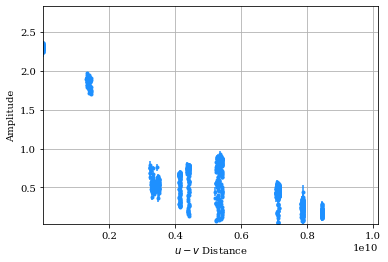

In [3]:
# load in the data
obs = eh.obsdata.load_uvfits(obspath)

obs.add_scans()

# # split the observations based upon the time
# obs_List = sw.splitObs(obs)

# coherently average data
# avg_time = 60
obs = obs.avg_coherent(60, scan_avg=False)

#plot the amplitude of the data
obs.plotall('uvdist', 'amp')

## Reconstruct movie with no warp field

In [4]:
!which ffmpeg

/home/abao/anaconda3/envs/dpi_torch/bin/ffmpeg


In [5]:
# https://stackoverflow.com/questions/42634997/how-do-i-properly-enable-ffmpeg-for-matplotlib-animation
plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg'

In [6]:
# split the obs into a list of obs at each time
obs_List = di.split_obs(obs)

Splitting Observation File into 61 scans


/home/abao/anaconda3/envs/dpi_torch/lib/python3.7/site-packages/ehtim/obsdata.py:508: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(datalist)


In [7]:
# initialize the mean and the image covariance for the prior. 
# this can be a single image to be the same mean and covariance for each 
# time, or different for each time by appending an image/matrix for each timestep

# initialize mean
meanImg = []
emptyprior = eh.image.make_square(obs, NPIX, fov)
gaussprior = emptyprior.add_gauss(flux, (fwhm, fwhm, 0, 0, 0))
meanImg.append(gaussprior.copy())

# initialize covariance
imCov = []
imCov.append( sw.gaussImgCovariance_2(meanImg[0], powerDropoff=2.0, frac=1./2.) )

# make the covariance matrix that says how much variation there should be between frames in time 
noiseCov_img = np.eye(npixels)*variance_img_diff

# initialize the flowbasis and get the initTheta which says how to specify no motion for the specified flow basis
init_x, init_y, flowbasis_x, flowbasis_y, initTheta = sw.affineMotionBasis_noTranslation(meanImg[0])

# run StarWarps to find the distribution of the image at each timestep
expVal_t, expVal_t_t, expVal_tm1_t, loglikelihood, apxImgs = sw.computeSuffStatistics(
    meanImg, imCov, obs_List, noiseCov_img, initTheta, init_x, init_y, 
    flowbasis_x, flowbasis_y, initTheta, method=warp_method, measurement=measurement, 
    interiorPriors=interiorPriors, numLinIters=numLinIters, compute_expVal_tm1_t=False)

Backward timestep 0 of 61 total timesteps....

processing image 60 of 61 ...

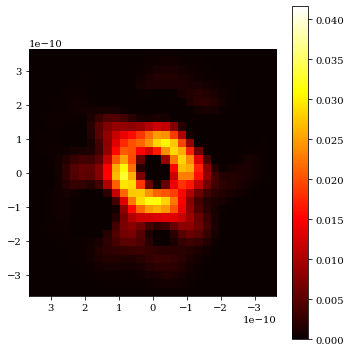

In [8]:
# save out results as a movie
if SAVE:
    # make the directory to save out the results
    try:
        os.stat(dirname)
    except:
        os.mkdir(dirname)
    
    # save out the movie that is generated assuming there is no motion
    sw.movie(expVal_t, out = dirname + '/movie_nomotion.mp4')

## Learn warp field and reconstruct movie using derived EM-algorithm

Iteration 0 of 31 ...
Backward timestep 0 of 61 total timesteps....

/home/abao/.local/lib/python3.7/site-packages/matplotlib/quiver.py:696: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


processing image 0 of 61 ...

/home/abao/.local/lib/python3.7/site-packages/matplotlib/quiver.py:696: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


Iteration 1 of 31 ...f 61 ...
processing image 60 of 61 ...al timesteps....

/home/abao/anaconda3/envs/dpi_torch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


Iteration 2 of 31 ...
processing image 60 of 61 ...al timesteps....

/home/abao/anaconda3/envs/dpi_torch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


Iteration 3 of 31 ...
processing image 60 of 61 ...al timesteps....

/home/abao/anaconda3/envs/dpi_torch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


Iteration 4 of 31 ...
processing image 60 of 61 ...al timesteps....

/home/abao/anaconda3/envs/dpi_torch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


Iteration 5 of 31 ...
processing image 60 of 61 ...al timesteps....

/home/abao/anaconda3/envs/dpi_torch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


Iteration 6 of 31 ...
processing image 60 of 61 ...al timesteps....

/home/abao/anaconda3/envs/dpi_torch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


Iteration 7 of 31 ...
processing image 60 of 61 ...al timesteps....

/home/abao/anaconda3/envs/dpi_torch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


Iteration 8 of 31 ...
processing image 60 of 61 ...al timesteps....

/home/abao/anaconda3/envs/dpi_torch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


Iteration 9 of 31 ...
processing image 60 of 61 ...al timesteps....

/home/abao/anaconda3/envs/dpi_torch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


Iteration 10 of 31 ...
Backward timestep 0 of 61 total timesteps....

/home/abao/anaconda3/envs/dpi_torch/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


processing image 0 of 61 ...

/home/abao/bouman_lab/DynamicDPI/DynamicDPItorch/starwarps_mod.py:815: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


processing image 60 of 61 ...

/home/abao/anaconda3/envs/dpi_torch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


Iteration 11 of 31 ...
Backward timestep 0 of 61 total timesteps....

/home/abao/anaconda3/envs/dpi_torch/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


processing image 0 of 61 ...

/home/abao/bouman_lab/DynamicDPI/DynamicDPItorch/starwarps_mod.py:815: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


processing image 60 of 61 ...

/home/abao/anaconda3/envs/dpi_torch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


Iteration 12 of 31 ...
Backward timestep 0 of 61 total timesteps....

/home/abao/anaconda3/envs/dpi_torch/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


processing image 0 of 61 ...

/home/abao/bouman_lab/DynamicDPI/DynamicDPItorch/starwarps_mod.py:815: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


processing image 60 of 61 ...

/home/abao/anaconda3/envs/dpi_torch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


Iteration 13 of 31 ...
Backward timestep 0 of 61 total timesteps....

/home/abao/anaconda3/envs/dpi_torch/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


processing image 0 of 61 ...

/home/abao/bouman_lab/DynamicDPI/DynamicDPItorch/starwarps_mod.py:815: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


processing image 60 of 61 ...

/home/abao/anaconda3/envs/dpi_torch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


Iteration 14 of 31 ...
Backward timestep 0 of 61 total timesteps....

/home/abao/anaconda3/envs/dpi_torch/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


processing image 0 of 61 ...

/home/abao/bouman_lab/DynamicDPI/DynamicDPItorch/starwarps_mod.py:815: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


processing image 60 of 61 ...

/home/abao/anaconda3/envs/dpi_torch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


Iteration 15 of 31 ...
Backward timestep 0 of 61 total timesteps....

/home/abao/anaconda3/envs/dpi_torch/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/abao/bouman_lab/DynamicDPI/DynamicDPItorch/starwarps_mod.py:815: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


processing image 60 of 61 ...

/home/abao/anaconda3/envs/dpi_torch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


Iteration 16 of 31 ...
Backward timestep 0 of 61 total timesteps....

/home/abao/anaconda3/envs/dpi_torch/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


processing image 0 of 61 ...

/home/abao/bouman_lab/DynamicDPI/DynamicDPItorch/starwarps_mod.py:815: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


processing image 60 of 61 ...

/home/abao/anaconda3/envs/dpi_torch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


Iteration 17 of 31 ...
Backward timestep 0 of 61 total timesteps....

/home/abao/anaconda3/envs/dpi_torch/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


processing image 0 of 61 ...

/home/abao/bouman_lab/DynamicDPI/DynamicDPItorch/starwarps_mod.py:815: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


processing image 60 of 61 ...

/home/abao/anaconda3/envs/dpi_torch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


Iteration 18 of 31 ...
Backward timestep 0 of 61 total timesteps....

/home/abao/anaconda3/envs/dpi_torch/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


processing image 0 of 61 ...

/home/abao/bouman_lab/DynamicDPI/DynamicDPItorch/starwarps_mod.py:815: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


processing image 60 of 61 ...

/home/abao/anaconda3/envs/dpi_torch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


Iteration 19 of 31 ...
Backward timestep 0 of 61 total timesteps....

/home/abao/anaconda3/envs/dpi_torch/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


processing image 0 of 61 ...

/home/abao/bouman_lab/DynamicDPI/DynamicDPItorch/starwarps_mod.py:815: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


processing image 60 of 61 ...

/home/abao/anaconda3/envs/dpi_torch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


Iteration 20 of 31 ...
Backward timestep 0 of 61 total timesteps....

/home/abao/anaconda3/envs/dpi_torch/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


processing image 0 of 61 ...

/home/abao/bouman_lab/DynamicDPI/DynamicDPItorch/starwarps_mod.py:815: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


processing image 60 of 61 ...

/home/abao/anaconda3/envs/dpi_torch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


Iteration 21 of 31 ...
Backward timestep 0 of 61 total timesteps....

/home/abao/anaconda3/envs/dpi_torch/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


processing image 0 of 61 ...

/home/abao/bouman_lab/DynamicDPI/DynamicDPItorch/starwarps_mod.py:815: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


processing image 60 of 61 ...

/home/abao/anaconda3/envs/dpi_torch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


Iteration 22 of 31 ...
Backward timestep 0 of 61 total timesteps....

/home/abao/anaconda3/envs/dpi_torch/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


processing image 0 of 61 ...

/home/abao/bouman_lab/DynamicDPI/DynamicDPItorch/starwarps_mod.py:815: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


processing image 60 of 61 ...

/home/abao/anaconda3/envs/dpi_torch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


Iteration 23 of 31 ...
Backward timestep 0 of 61 total timesteps....

/home/abao/anaconda3/envs/dpi_torch/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


processing image 0 of 61 ...

/home/abao/bouman_lab/DynamicDPI/DynamicDPItorch/starwarps_mod.py:815: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


processing image 60 of 61 ...

/home/abao/anaconda3/envs/dpi_torch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


Iteration 24 of 31 ...
Backward timestep 0 of 61 total timesteps....

/home/abao/anaconda3/envs/dpi_torch/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


processing image 0 of 61 ...

/home/abao/bouman_lab/DynamicDPI/DynamicDPItorch/starwarps_mod.py:815: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


processing image 60 of 61 ...

/home/abao/anaconda3/envs/dpi_torch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


Iteration 25 of 31 ...
Backward timestep 0 of 61 total timesteps....

/home/abao/anaconda3/envs/dpi_torch/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


processing image 1 of 61 ...

/home/abao/bouman_lab/DynamicDPI/DynamicDPItorch/starwarps_mod.py:815: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


processing image 60 of 61 ...

/home/abao/anaconda3/envs/dpi_torch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


Iteration 26 of 31 ...
Backward timestep 0 of 61 total timesteps....

/home/abao/anaconda3/envs/dpi_torch/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


processing image 0 of 61 ...

/home/abao/bouman_lab/DynamicDPI/DynamicDPItorch/starwarps_mod.py:815: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


processing image 60 of 61 ...

/home/abao/anaconda3/envs/dpi_torch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


Iteration 27 of 31 ...
Backward timestep 0 of 61 total timesteps....

/home/abao/anaconda3/envs/dpi_torch/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


processing image 0 of 61 ...

/home/abao/bouman_lab/DynamicDPI/DynamicDPItorch/starwarps_mod.py:815: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


processing image 60 of 61 ...

/home/abao/anaconda3/envs/dpi_torch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


Iteration 28 of 31 ...
Backward timestep 0 of 61 total timesteps....

/home/abao/anaconda3/envs/dpi_torch/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


processing image 0 of 61 ...

/home/abao/bouman_lab/DynamicDPI/DynamicDPItorch/starwarps_mod.py:815: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


processing image 60 of 61 ...

/home/abao/anaconda3/envs/dpi_torch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


Iteration 29 of 31 ...
Backward timestep 0 of 61 total timesteps....

/home/abao/anaconda3/envs/dpi_torch/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


processing image 0 of 61 ...

/home/abao/bouman_lab/DynamicDPI/DynamicDPItorch/starwarps_mod.py:815: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


processing image 60 of 61 ...

/home/abao/anaconda3/envs/dpi_torch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


Iteration 30 of 31 ...
Backward timestep 0 of 61 total timesteps....

/home/abao/anaconda3/envs/dpi_torch/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


processing image 0 of 61 ...

/home/abao/bouman_lab/DynamicDPI/DynamicDPItorch/starwarps_mod.py:815: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


processing image 60 of 61 ...

/home/abao/anaconda3/envs/dpi_torch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
/home/abao/.local/lib/python3.7/site-packages/matplotlib/quiver.py:696: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


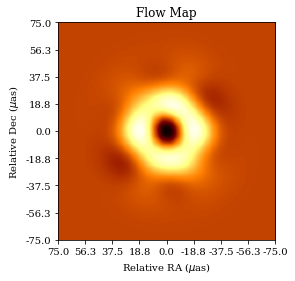

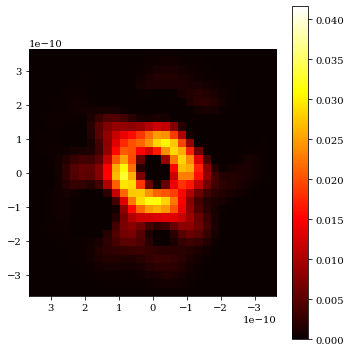

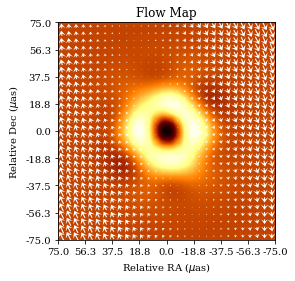

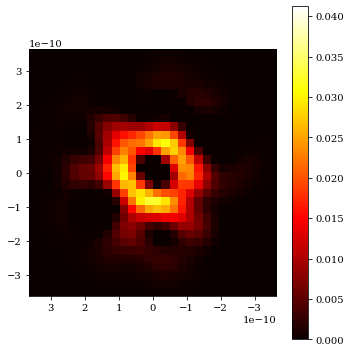

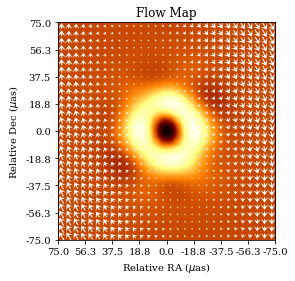

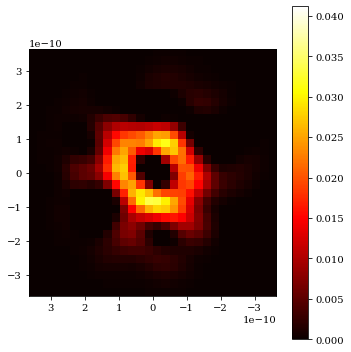

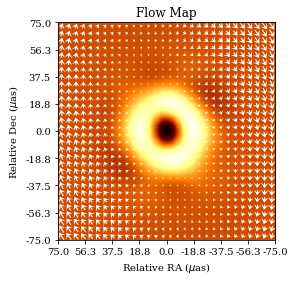

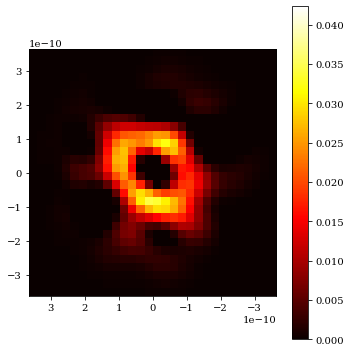

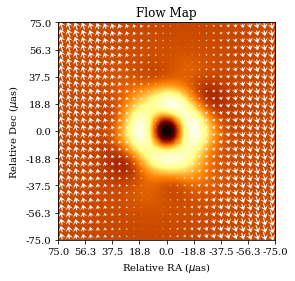

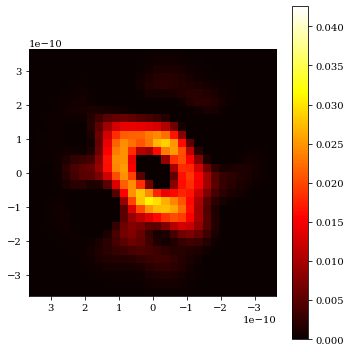

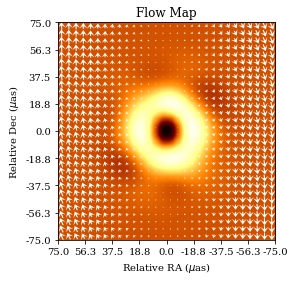

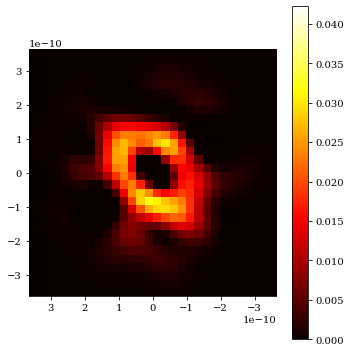

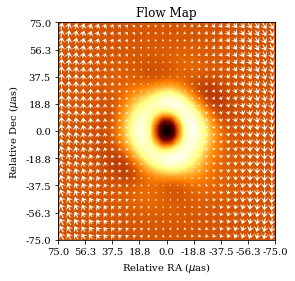

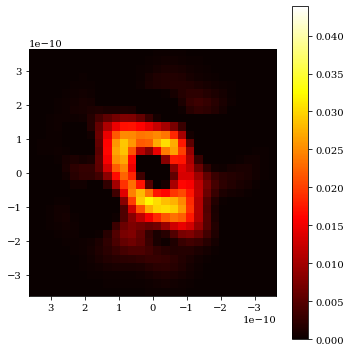

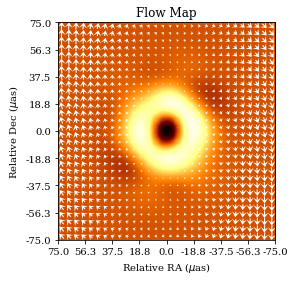

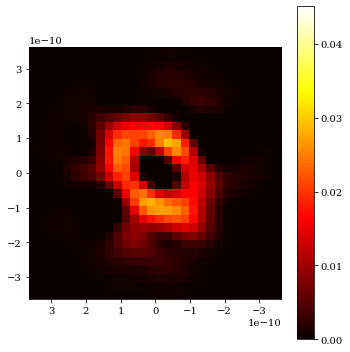

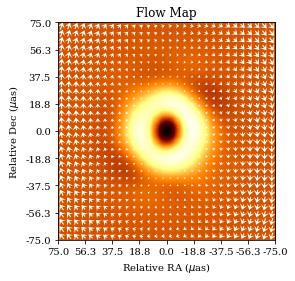

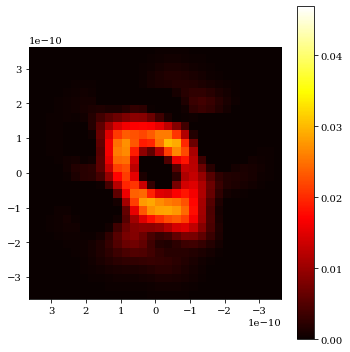

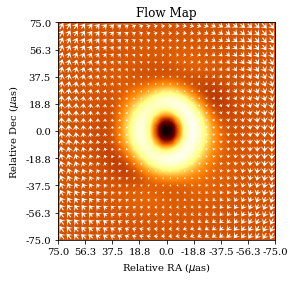

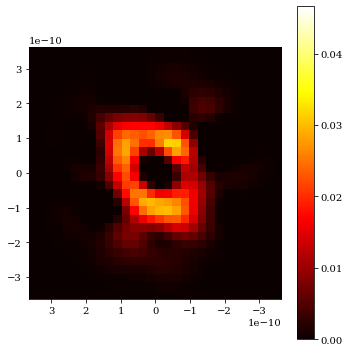

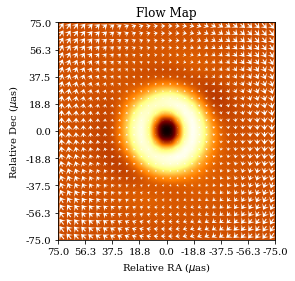

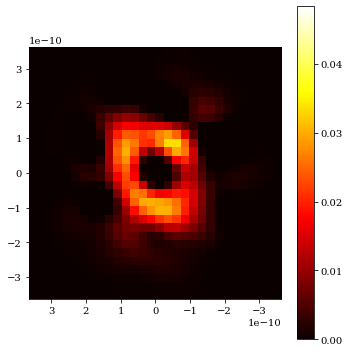

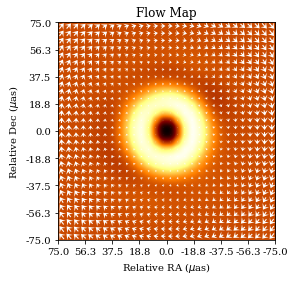

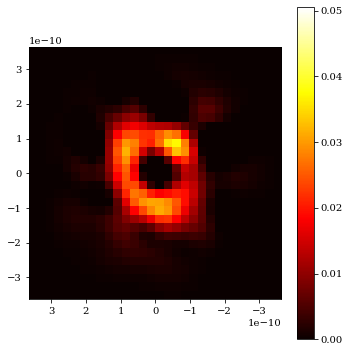

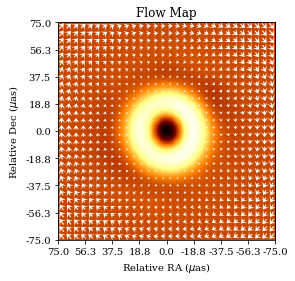

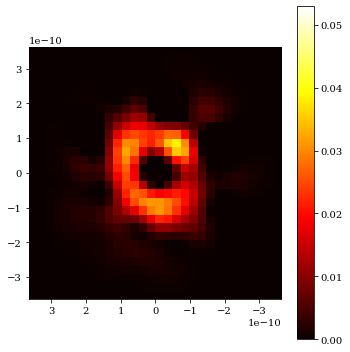

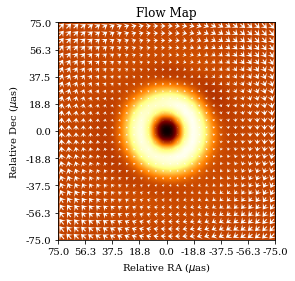

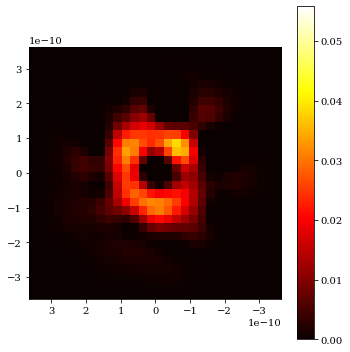

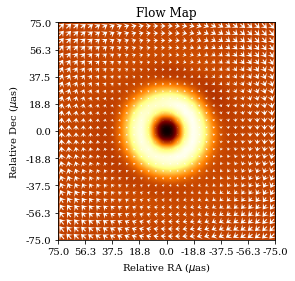

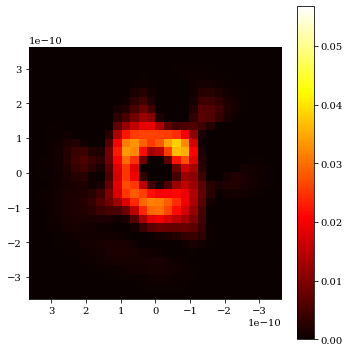

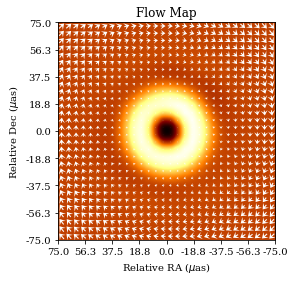

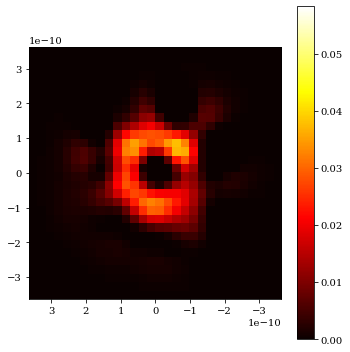

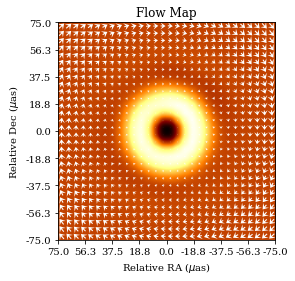

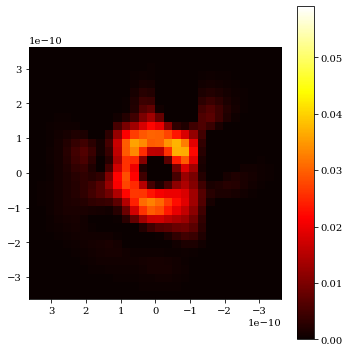

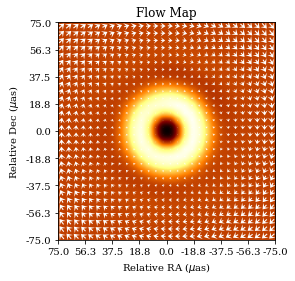

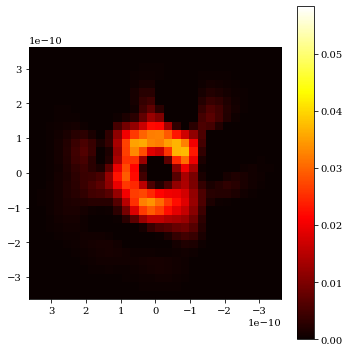

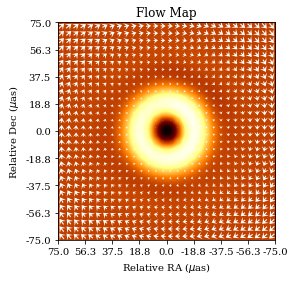

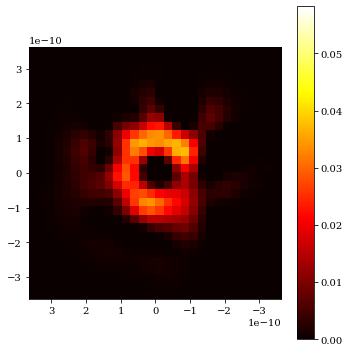

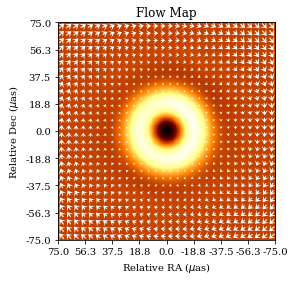

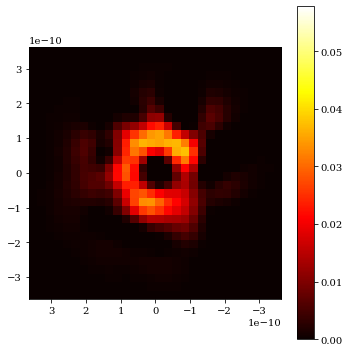

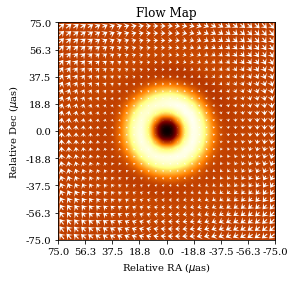

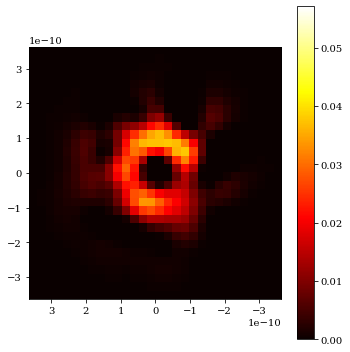

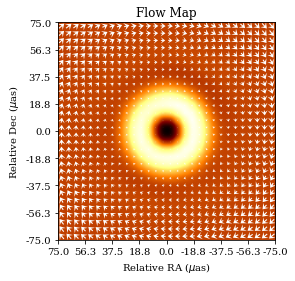

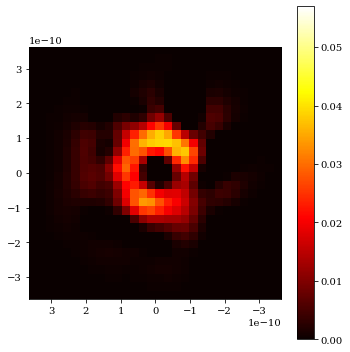

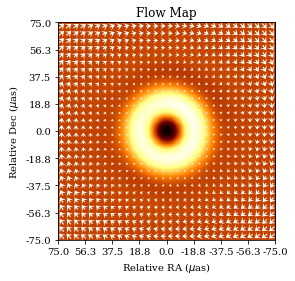

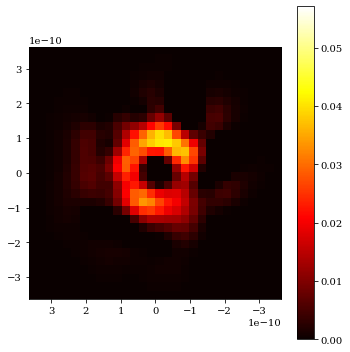

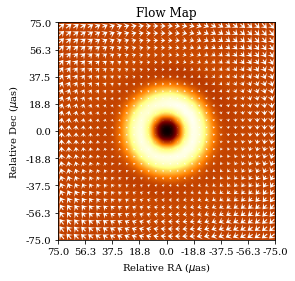

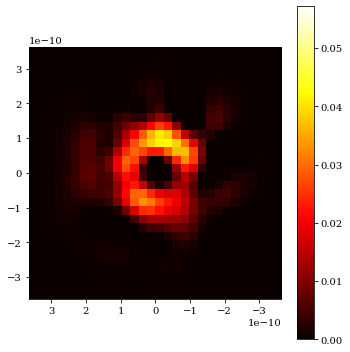

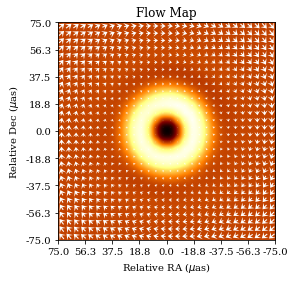

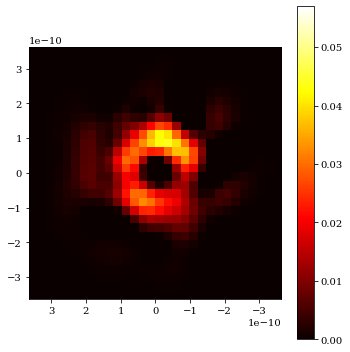

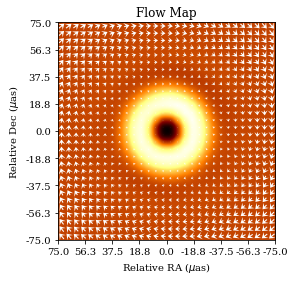

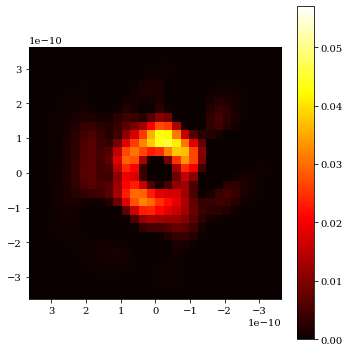

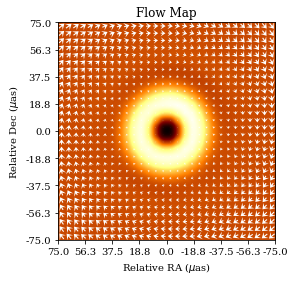

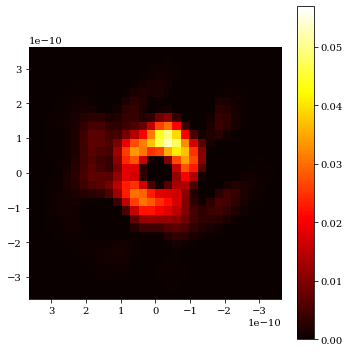

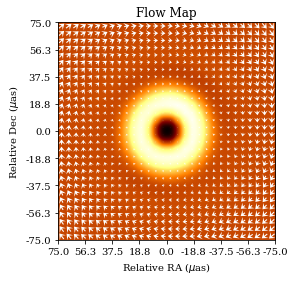

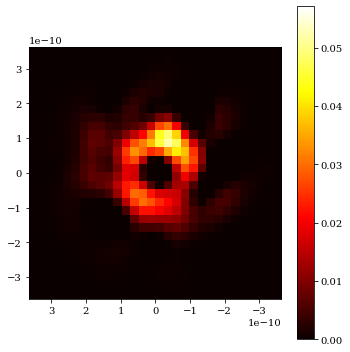

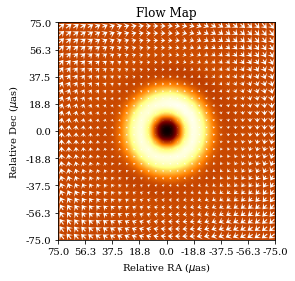

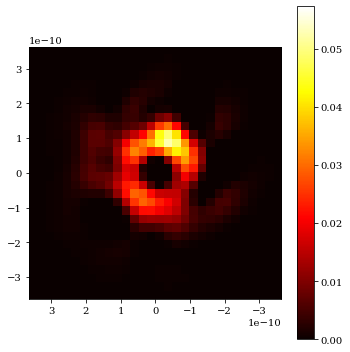

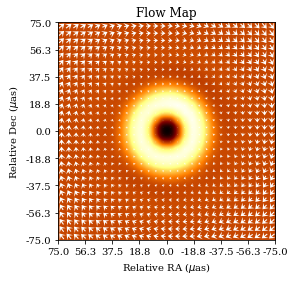

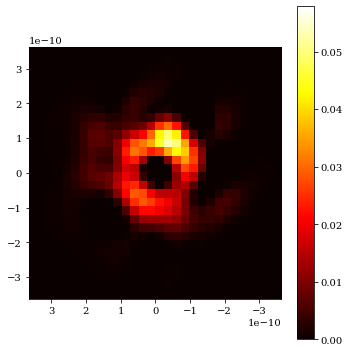

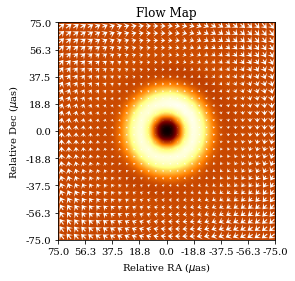

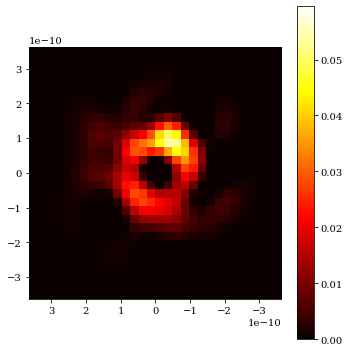

In [9]:
# number of motion parameters
nbasis = flowbasis_x.shape[2] 

# set the bounds for the motion parameters
bnds = []
for b in range(0,nbasis):
    bnds.append( (-1.5,1.5) )


# initialize optimization parameters
newTheta = copy.deepcopy(initTheta)
feval = 0.0
optdict = {'maxiter':maxit, 'ftol':stop, 'maxcor':NHIST, 'disp':True} # minimizer params
negll = []
thetas = []
fevals = []

for iter in range(0, nIters+1):

    print('\rIteration %i of %i ...' % (iter, nIters+1) )
    
    # ========== E-step ========== #
    if iter==0 or reassign_apxImgs:
        apxImgs = False

    # solve for the sufficient statistics using the StarWarps approach with the previous value 
    # the warp parameters in newTheta
    expVal_t, expVal_t_t, expVal_tm1_t, loglikelihood, apxImgs = sw.computeSuffStatistics(
        meanImg, imCov, obs_List, noiseCov_img, newTheta, init_x, init_y, 
        flowbasis_x, flowbasis_y, initTheta, method=warp_method, measurement=measurement, 
        interiorPriors=interiorPriors, numLinIters=numLinIters)

    # save the negative log likelihood (nll), the value of the warp parameters (thetas) 
    # and the evaluation of the optimization function (feval)
    negll.append(-loglikelihood[2])
    thetas.append(newTheta)
    fevals.append(feval)
    
    # ========== visualize and save results ========== #
    
    if SAVE: 
    
        # make the directory to save out the results
        try:
            os.stat(dirname + '/' + str(iter))
        except:
            os.mkdir(dirname + '/' + str(iter))
    
        # save frames as the mean and the estimated standard deviation of each frame
        stdevImg = meanImg[0].copy()
        for i in range(0,len(obs_List)):
            stdevImg.imvec = np.sqrt(np.diag(expVal_t_t[i]))
            expVal_t[i].save_fits(dirname + '/' + str(iter) + '/mean_' + str(i) + '.fits')
            stdevImg.save_fits(dirname + '/' + str(iter) +  '/stdev_' + str(i) + '.fits')

        # compute the average image
        avgImg = meanImg[0].copy()
        avgImg.imvec = np.mean([im.imvec for im in expVal_t],axis=0)
    
        #save flow diagram
        plt.figure(), sw.plot_Flow(avgImg, thetas[iter], init_x, init_y, flowbasis_x, flowbasis_y, initTheta, step=1)
        plt.savefig(dirname + '/flow_' + str(iter) +  '.pdf')

        #save a movie
        sw.movie(expVal_t, dirname + '/movie_' + str(iter) + '.mp4')

        # save out mat file with the information
        scipy.io.savemat(dirname + '/info_' + str(iter) + '.mat', {'negll':negll, 'thetas':thetas, 'funeval':fevals})
    
    # ========== M-step ========== #
    if iter < nIters:
        result = opt.minimize(sw.expnegloglikelihood, newTheta, args=(expVal_t, expVal_t_t, expVal_tm1_t, meanImg, imCov, obs_List, noiseCov_img, init_x, init_y, flowbasis_x, flowbasis_y, initTheta, warp_method), method='L-BFGS-B', jac=sw.deriv_expnegloglikelihood, bounds=bnds, options=optdict)
        newTheta = result.x
        feval = result.fun
